In [42]:
import numpy as np
import matplotlib.pyplot as plt
from pycircstat.descriptive import mean as cmean

In [188]:

def sim_I_phase_curve(I_max, noise_sd=0, EC_phaseshift=-70, I_base=0, phase_m=1):
    dt = 0.1
    # izhi_a = 0.02
    # izhi_b = 0.2
    # izhi_c = -55
    # izhi_d = 4
    izhi_a = 0.035
    izhi_b = 0.2
    izhi_c = -60
    izhi_d = 8

    V_thresh = 30
    theta_amp = 7
    theta_f = 10
    EC_phase = np.deg2rad(360+EC_phaseshift)
    EC_posoffset = (np.cos(EC_phase) + 1)/2 * theta_amp
    ECstf_rest= 0.25
    ECstf_target= 1.5
    tau_ECstf= 0.5e3
    U_ECstf= 0.001


    I_pos = I_max + EC_posoffset


    v = izhi_c
    u = 0

    t = np.arange(0, 500+dt, dt)
    # I_pos = t/t.max() * I_pos
    I_pos = np.ones(len(t)) * I_pos
    theta_T = 1/theta_f * 1e3
    theta_phase = np.mod(t, theta_T)/theta_T * 2*np.pi
    Itheta = (1 + np.cos(theta_phase))/2 * theta_amp
    ECtheta = (np.cos(theta_phase + EC_phase) + 1)/2
    tidxsp = []
    allv = np.zeros(len(t))
    allIsen_fac = np.zeros(len(t))
    ECstfx = ECstf_rest
    noise_arr = np.random.normal(0, noise_sd, size=len(t))
    for tidx in range(len(t)):

        Isen = I_pos[tidx] * (1-phase_m) + I_pos[tidx] * phase_m * ECtheta[tidx]

        ECstfx += ((ECstf_rest-ECstfx)/tau_ECstf + (ECstf_target - ECstfx) * U_ECstf * Isen) * dt
        Isen_fac = np.square(ECstfx) * Isen

        Itotal = Isen_fac - Itheta[tidx] + noise_arr[tidx] + I_base

        # Izhikevich
        v += (0.04*v**2 + 5*v + 140 - u + Itotal) * dt
        u += izhi_a * (izhi_b * v - u) * dt
        if v>V_thresh:
            tidxsp.append(tidx)
            v = izhi_c
            u = u + izhi_d

        allv[tidx] = v
        allIsen_fac[tidx] = Isen_fac

    tidxsp = np.array(tidxsp)
    if tidxsp.shape[0] < 1:
        phasesp = np.array([])
    else:
        phasesp = theta_phase[tidxsp]

    info = (t, tidxsp, theta_phase, allIsen_fac, Itheta)
    return info, phasesp

In [180]:

dI = 0.1
Imax_ax = np.arange(0, 20 + dI, dI)
all_phase_mu = np.zeros(len(Imax_ax))
all_phasesp = []
for i in range(len(Imax_ax)):
    I_max = Imax_ax[i]
    _, phasesp = sim_I_phase_curve(I_max, EC_phaseshift=-70, phase_m=1)
    if phasesp.shape[0] < 1:
        mean_phase = None
    else:
        mean_phase = cmean(phasesp)
    all_phase_mu[i] = mean_phase

    all_phasesp.append(phasesp)

fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(Imax_ax, all_phase_mu, c='r', lw=4)
ax.set_ylim(0, 2*np.pi)
for i in range(len(Imax_ax)):
    phasesp = all_phasesp[i]
    ax.scatter([Imax_ax[i]] * len(phasesp), phasesp, marker='.', color='k')


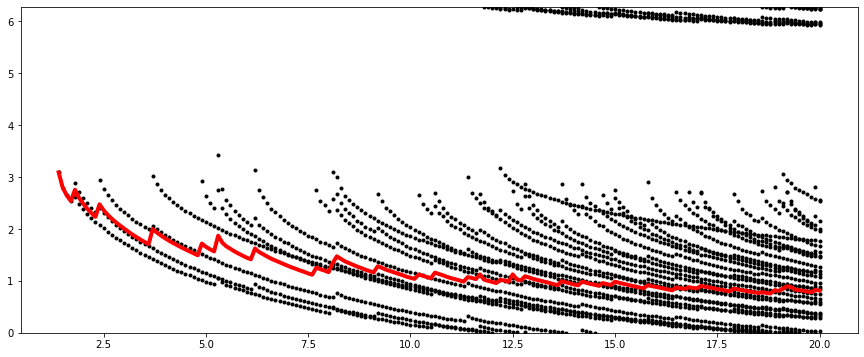

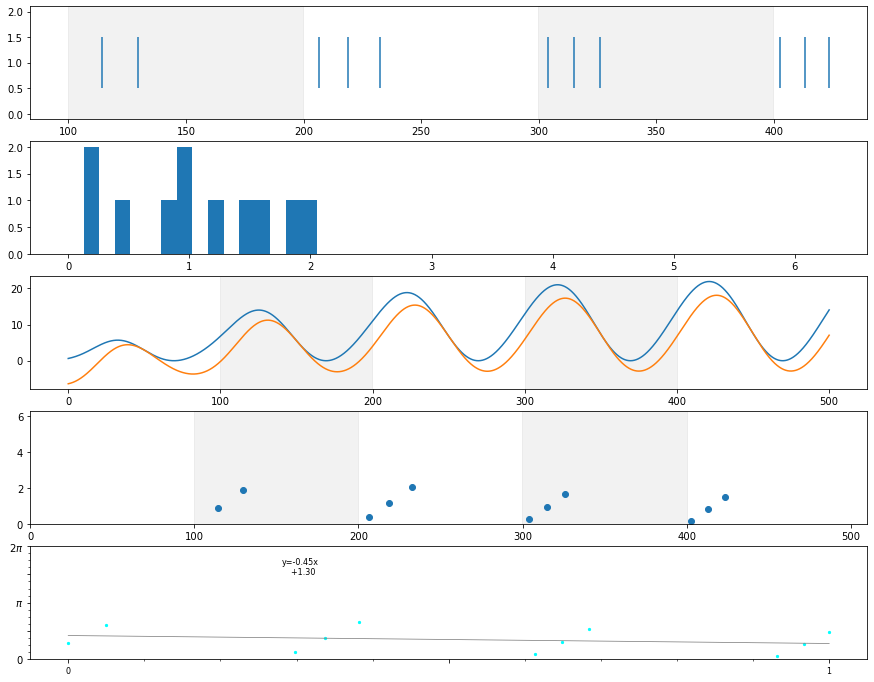

In [189]:
from library.visualization import plot_phase_precession

info, phasesp = sim_I_phase_curve(10, EC_phaseshift=-70, phase_m=1)

t, tidxsp, theta_phase, allIsen_fac, Itheta = info
tsp = t[tidxsp]
fig, ax = plt.subplots(5, 1, figsize=(15, 12))
ax[0].eventplot(t[tidxsp])
theta_cutidx = np.where(np.diff(theta_phase) < -6)[0]
for j in range(len(theta_cutidx) - 1):
    if j % 2 == 0:
        cutidx1, cutidx2 = theta_cutidx[j], theta_cutidx[j + 1]
        ax[0].axvspan(t[cutidx1], t[cutidx2], color='gray', alpha=0.1)
        ax[2].axvspan(t[cutidx1], t[cutidx2], color='gray', alpha=0.1)
        ax[3].axvspan(t[cutidx1], t[cutidx2], color='gray', alpha=0.1)
_ = ax[1].hist(phasesp, bins=np.linspace(0, 2*np.pi, 50))

ax[2].plot(t, allIsen_fac)
ax[2].plot(t, allIsen_fac-Itheta)
ax[3].scatter(tsp, phasesp)
ax[3].set_xlim(0, t.max()+10)
ax[3].set_ylim(0, 2*np.pi)

dsp = (tsp - tsp.min()) / (tsp.max() - tsp.min())
plot_phase_precession(ax[4], dsp, phasesp, s=20, c='cyan', label='', fontsize=8, plotmeanphase=False, statxy=(0.3, 0.75))



In [36]:
theta_phase.min()

0.0